# The Aiyagari Model

## Contents

- [The Aiyagari Model](#The-Aiyagari-Model)  
  - [Overview](#Overview)  
  - [The Economy](#The-Economy)  
  - [Firms](#Firms)  
  - [Code](#Code)  

## Overview

In this lecture we describe the structure of a class of models that build on work by Truman Bewley [[Bew77]](https://lectures.quantecon.org/py/zreferences.html#bewley1977)

We begin by discussing an example of a Bewley model due to <a href=/_static/pdfs/aiyagari_obit.pdf download>Rao Aiyagari</a>

The model features

- Heterogeneous agents  
- A single exogenous vehicle for borrowing and lending  
- Limits on amounts individual agents may borrow  


The Aiyagari model has been used to investigate many topics, including

- precautionary savings and the effect of liquidity constraints [[Aiy94]](https://lectures.quantecon.org/py/zreferences.html#aiyagari1994)  
- risk sharing and asset pricing [[HL96]](https://lectures.quantecon.org/py/zreferences.html#heaton1996)  
- the shape of the wealth distribution [[BBZ15]](https://lectures.quantecon.org/py/zreferences.html#benhabib2015)  
- etc., etc., etc.  

### References

The primary reference for this lecture is [[Aiy94]](https://lectures.quantecon.org/py/zreferences.html#aiyagari1994)

A textbook treatment is available in chapter 18 of [[LS18]](https://lectures.quantecon.org/py/zreferences.html#ljungqvist2012)

A continuous time version of the model by SeHyoun Ahn and Benjamin Moll can be found [here](http://nbviewer.jupyter.org/github/QuantEcon/QuantEcon.notebooks/blob/master/aiyagari_continuous_time.ipynb)

## The Economy

### Households

Infinitely lived households / consumers face idiosyncratic income shocks

A unit interval of  *ex ante* identical households face a common borrowing constraint

The savings problem faced by a typical  household is

$$
\max \mathbb E \sum_{t=0}^{\infty} \beta^t u(c_t)
$$

subject to

$$
a_{t+1} + c_t \leq w z_t + (1 + r) a_t
\quad
c_t \geq 0,
\quad \text{and} \quad
a_t \geq -B
$$

where

- $ c_t $ is current consumption  
- $ a_t $ is assets  
- $ z_t $ is an exogenous component of labor income capturing stochastic unemployment risk, etc.  
- $ w $ is a wage rate  
- $ r $ is a net interest rate  
- $ B $ is the maximum amount that the agent is allowed to borrow  


The exogenous process $ \{z_t\} $ follows a finite state Markov chain with given stochastic matrix $ P $

The wage and interest rate are fixed over time

In this simple version of the model, households supply labor  inelastically because they do not value leisure

## Firms

Firms produce output by hiring capital and labor

Firms act competitively and face constant returns to scale

Since returns to scale are constant the number of firms does not matter

Hence we can consider a single (but nonetheless competitive) representative firm

The firm’s output is

$$
Y_t = A K_t^{\alpha} N^{1 - \alpha}
$$

where

- $ A $ and $ \alpha $ are parameters with $ A > 0 $ and $ \alpha \in (0, 1) $  
- $ K_t $ is aggregate capital  
- $ N $ is total labor supply (which is constant in this simple version of the model)  


The firm’s problem is

$$
max_{K, N} \left\{ A K_t^{\alpha} N^{1 - \alpha} - (r + \delta) K - w N \right\}
$$

The parameter $ \delta $ is the depreciation rate

From the first-order condition with respect to capital, the firm’s inverse demand for capital is


<a id='equation-aiy-rgk'></a>
$$
r = A \alpha  \left( \frac{N}{K} \right)^{1 - \alpha} - \delta \tag{1}
$$

Using this expression and the firm’s first-order condition for labor, we can pin down
the equilibrium wage rate as a function of $ r $ as


<a id='equation-aiy-wgr'></a>
$$
w(r) = A  (1 - \alpha)  (A \alpha / (r + \delta))^{\alpha / (1 - \alpha)} \tag{2}
$$

### Equilibrium

We construct  a *stationary rational expectations equilibrium* (SREE)

In such an equilibrium

- prices induce behavior that generates aggregate quantities consistent with the prices  
- aggregate quantities and prices are constant over time  


In more detail, an SREE lists a set of prices, savings and production policies such that

- households want to choose the specified savings policies taking the prices as given  
- firms maximize profits taking the same prices as given  
- the resulting aggregate quantities are consistent with the prices; in particular, the demand for capital equals the supply  
- aggregate quantities (defined as cross-sectional averages) are constant  


In practice, once parameter values are set, we can check for an SREE by the following steps

1. pick a proposed quantity $ K $ for aggregate capital  
1. determine corresponding prices, with interest rate $ r $ determined by [(1)](#equation-aiy-rgk) and a wage rate $ w(r) $ as given in [(2)](#equation-aiy-wgr)  
1. determine the common optimal savings policy of the households given these prices  
1. compute aggregate capital as the mean of steady state capital given this savings policy  


If this final quantity agrees with $ K $ then we have a SREE

## Code

Let’s look at how we might compute such an equilibrium in practice

To solve the household’s dynamic programming problem we’ll use the [DiscreteDP](https://github.com/QuantEcon/QuantEcon.py/blob/master/quantecon/markov/ddp.py) class from [QuantEcon.py](http://quantecon.org/python_index.html)

Our first task is the least exciting one: write code that maps parameters for a household problem into the `R` and `Q` matrices needed to generate an instance of `DiscreteDP`

Below is a piece of boilerplate code that does just this

In reading the code, the following information will be helpful

- `R` needs to be a matrix where `R[s, a]` is the reward at state `s` under action `a`  
- `Q` needs to be a three dimensional array where `Q[s, a, s']` is the probability of transitioning to state `s'` when the current state is `s` and the current action is `a`  


(For a detailed discussion of `DiscreteDP` see [this lecture](https://lectures.quantecon.org/py/discrete_dp.html))

Here we take the state to be $ s_t := (a_t, z_t) $, where $ a_t $ is assets and $ z_t $ is the shock

The action is the choice of next period asset level $ a_{t+1} $

We use Numba to speed up the loops so we can update the matrices efficiently
when the parameters change

The class also includes a default set of parameters that we’ll adopt unless otherwise specified

In [1]:
import numpy as np
from numba import jit

class Household:
    """
    This class takes the parameters that define a household asset accumulation
    problem and computes the corresponding reward and transition matrices R
    and Q required to generate an instance of DiscreteDP, and thereby solve
    for the optimal policy.

    Comments on indexing: We need to enumerate the state space S as a sequence
    S = {0, ..., n}.  To this end, (a_i, z_i) index pairs are mapped to s_i
    indices according to the rule

        s_i = a_i * z_size + z_i 

    To invert this map, use
    
        a_i = s_i // z_size  (integer division)
        z_i = s_i % z_size

    """


    def __init__(self,
                 r=0.01,                      # interest rate
                 w=1.0,                       # wages
                 β=0.96,                      # discount factor
                 a_min=1e-10,
                 Π=[[0.9, 0.1], [0.1, 0.9]],  # Markov chain
                 z_vals=[0.1, 1.0],           # exogenous states
                 a_max=18,
                 a_size=200):

        # Store values, set up grids over a and z
        self.r, self.w, self.β = r, w, β
        self.a_min, self.a_max, self.a_size = a_min, a_max, a_size

        self.Π = np.asarray(Π)
        self.z_vals = np.asarray(z_vals)
        self.z_size = len(z_vals)

        self.a_vals = np.linspace(a_min, a_max, a_size)
        self.n = a_size * self.z_size

        # Build the array Q
        self.Q = np.zeros((self.n, a_size, self.n))
        self.build_Q()

        # Build the array R
        self.R = np.empty((self.n, a_size))
        self.build_R()

    def set_prices(self, r, w):
        """
        Use this method to reset prices.  Calling the method will trigger a
        re-build of R.
        """
        self.r, self.w = r, w
        self.build_R()

    def build_Q(self):
        populate_Q(self.Q, self.a_size, self.z_size, self.Π)

    def build_R(self):
        self.R.fill(-np.inf)
        populate_R(self.R, self.a_size, self.z_size, self.a_vals, self.z_vals, self.r, self.w)


# Do the hard work using JIT-ed functions

@jit(nopython=True)
def populate_R(R, a_size, z_size, a_vals, z_vals, r, w):
    n = a_size * z_size
    for s_i in range(n):
        a_i = s_i // z_size
        z_i = s_i % z_size
        a = a_vals[a_i]
        z = z_vals[z_i]
        for new_a_i in range(a_size):
            a_new = a_vals[new_a_i]
            c = w * z + (1 + r) * a - a_new
            if c > 0:
                R[s_i, new_a_i] = np.log(c)  # Utility

@jit(nopython=True)
def populate_Q(Q, a_size, z_size, Π):
    n = a_size * z_size
    for s_i in range(n):
        z_i = s_i % z_size
        for a_i in range(a_size):
            for next_z_i in range(z_size):
                Q[s_i, a_i, a_i * z_size + next_z_i] = Π[z_i, next_z_i]


@jit(nopython=True)
def asset_marginal(s_probs, a_size, z_size):
    a_probs = np.zeros(a_size)
    for a_i in range(a_size):
        for z_i in range(z_size):
            a_probs[a_i] += s_probs[a_i * z_size + z_i]
    return a_probs

As a first example of what we can do, let’s compute and plot an optimal accumulation policy at fixed prices

In [2]:
import quantecon as qe
import matplotlib.pyplot as plt
from quantecon.markov import DiscreteDP

# Example prices
r = 0.03
w = 0.956

# Create an instance of Household
am = Household(a_max=20, r=r, w=w)

# Use the instance to build a discrete dynamic program
am_ddp = DiscreteDP(am.R, am.Q, am.β)

# Solve using policy function iteration
results = am_ddp.solve(method='policy_iteration')

# Simplify names
z_size, a_size = am.z_size, am.a_size
z_vals, a_vals = am.z_vals, am.a_vals
n = a_size * z_size

# Get all optimal actions across the set of a indices with z fixed in each row
a_star = np.empty((z_size, a_size))
for s_i in range(n):
    a_i = s_i // z_size
    z_i = s_i % z_size
    a_star[z_i, a_i] = a_vals[results.sigma[s_i]]

fig, ax = plt.subplots(figsize=(9, 9))
ax.plot(a_vals, a_vals, 'k--')  # 45 degrees
for i in range(z_size):
    lb = f'$z = {z_vals[i]:.2}$'
    ax.plot(a_vals, a_star[i, :], lw=2, alpha=0.6, label=lb)
    ax.set_xlabel('current assets')
    ax.set_ylabel('next period assets')
ax.legend(loc='upper left')

plt.show()

<Figure size 900x900 with 1 Axes>

The plot shows asset accumulation policies at different values of the exogenous state

Now we want to calculate the equilibrium

Let’s do this visually as a first pass

The following code draws aggregate supply and demand curves

The intersection gives equilibrium interest rates and capital

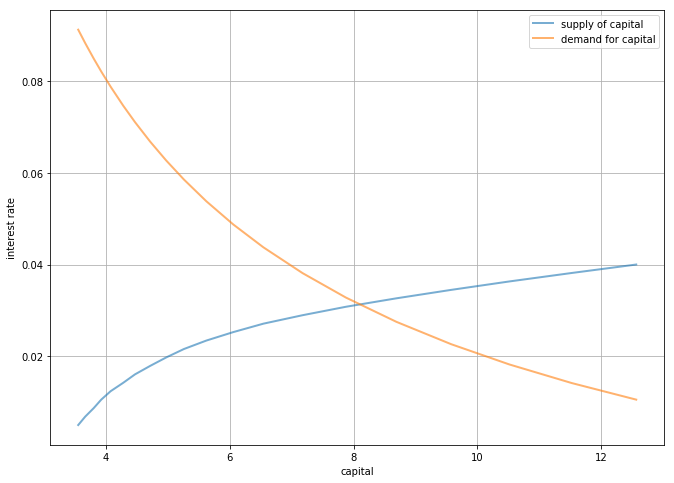

In [3]:
A = 1.0
N = 1.0
α = 0.33
β = 0.96
δ = 0.05


def r_to_w(r):
    """
    Equilibrium wages associated with a given interest rate r.
    """
    return A * (1 - α) * (A * α / (r + δ))**(α / (1 - α))

def rd(K):
    """
    Inverse demand curve for capital.  The interest rate associated with a
    given demand for capital K.
    """
    return A * α * (N / K)**(1 - α) - δ


def prices_to_capital_stock(am, r):
    """
    Map prices to the induced level of capital stock.
    
    Parameters:
    ----------
    
    am : Household
        An instance of an aiyagari_household.Household 
    r : float
        The interest rate
    """
    w = r_to_w(r)
    am.set_prices(r, w)
    aiyagari_ddp = DiscreteDP(am.R, am.Q, β)
    # Compute the optimal policy
    results = aiyagari_ddp.solve(method='policy_iteration')
    # Compute the stationary distribution
    stationary_probs = results.mc.stationary_distributions[0]
    # Extract the marginal distribution for assets
    asset_probs = asset_marginal(stationary_probs, am.a_size, am.z_size)
    # Return K
    return np.sum(asset_probs * am.a_vals)


# Create an instance of Household
am = Household(a_max=20)

# Use the instance to build a discrete dynamic program
am_ddp = DiscreteDP(am.R, am.Q, am.β)

# Create a grid of r values at which to compute demand and supply of capital
num_points = 20
r_vals = np.linspace(0.005, 0.04, num_points)

# Compute supply of capital
k_vals = np.empty(num_points)
for i, r in enumerate(r_vals):
    k_vals[i] = prices_to_capital_stock(am, r)

# Plot against demand for capital by firms
fig, ax = plt.subplots(figsize=(11, 8))
ax.plot(k_vals, r_vals, lw=2, alpha=0.6, label='supply of capital')
ax.plot(k_vals, rd(k_vals), lw=2, alpha=0.6, label='demand for capital')
ax.grid()
ax.set_xlabel('capital')
ax.set_ylabel('interest rate')
ax.legend(loc='upper right')

plt.show()